In [1]:
import gc

import mlcrate as mlc
import pickle as pkl

from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Dot, Reshape, Add, Subtract
from keras import objectives
from keras import backend as K
from keras import regularizers 
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
import tqdm

import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
import tqdm
import os
warnings.filterwarnings('ignore')
print(os.listdir('../input/elo-merchant-category-recommendation/'))

Using TensorFlow backend.


['test.csv', 'merchants.csv', 'train.csv', 'Data_Dictionary.xlsx', 'new_merchant_transactions.csv', 'sample_submission.csv', 'historical_transactions.csv']


In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [3]:
df_otrain=reduce_mem_usage(pd.read_csv('../input/elo-merchant-category-recommendation/train.csv'))
df_otest=reduce_mem_usage(pd.read_csv('../input/elo-merchant-category-recommendation/test.csv'))
df_hist=reduce_mem_usage(pd.read_csv('../input/elo-merchant-category-recommendation/historical_transactions.csv', usecols=['card_id','subsector_id','merchant_category_id','state_id','city_id','category_1','category_2','category_3','purchase_amount','purchase_date','month_lag','merchant_id']))
df_new_hist=reduce_mem_usage(pd.read_csv('../input/elo-merchant-category-recommendation/new_merchant_transactions.csv',usecols=['card_id','subsector_id','merchant_category_id','state_id','city_id','category_1','category_2','category_3','purchase_amount','purchase_date','month_lag','merchant_id']))

Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)
Mem. usage decreased to 1471.48 Mb (44.8% reduction)
Mem. usage decreased to 95.48 Mb (46.9% reduction)


In [4]:
dat_day=pd.to_datetime(pd.Series(['2019-02-26']))
def add_new(df,i):
    df['purchase_date']=pd.to_datetime(df['purchase_date'])
    df['sub_count']=df.groupby(['card_id','subsector_id'])['subsector_id'].transform('count')
    df['state_count']=df.groupby(['card_id','state_id'])['state_id'].transform('count')
    df['mc_count']=df.groupby(['card_id','merchant_category_id'])['merchant_category_id'].transform('count')
    df['city_count']=df.groupby(['card_id','city_id'])['city_id'].transform('count')
    ohe_c1=pd.get_dummies(df['category_1'], prefix='category1_')
    ohe_c3=pd.get_dummies(df['category_3'],prefix='category3_')
    #df.drop(['category_1','category_3'],axis=1, inplace=True)
    df=df.join(ohe_c1)
    df=df.join(ohe_c3)
#     df['amount_differ'] = df.groupby(['card_id'])['purchase_amount'].agg(['diff'])
#     df['purchase_new']=np.round(df['purchase_amount'] / 0.00150265118 + 497.06,2)
#     df['amount_differ']=df.groupby(['card_id'])['purchase_new'].agg('diff')
    #df['Christmas_Day_2017']=(pd.to_datetime('2017-12-25')-df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Black Friday : 24th November 2017
#     df['Black_Friday_2017']=(pd.to_datetime('2017-11-24') - df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
#      #Childrens day: October 12 2017
#     df['Children_day_2017']=(pd.to_datetime('2017-10-12')-df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
#       #2018
#     #Mothers Day: May 13 2018
#     df['Mothers_Day_2018']=(pd.to_datetime('2018-05-13')-df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    
#     if i!=0:
#         #Mothers Day: May 14 2017
#         df['Mothers_Day_2017']=(pd.to_datetime('2017-06-04')-df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
#         #fathers day: August 13 2017
#         df['fathers_day_2017']=(pd.to_datetime('2017-08-13')-df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
         #Valentine's Day : 12th June, 2017
        #df['Valentine_Day_2017']=(pd.to_datetime('2017-06-12')-df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    
#     df['month_diff'] = ((dat_day[0] - df['purchase_date']).dt.days)//30
#     df['month_diff'] += df['month_lag']
#     df['duration'] = df['purchase_amount']*df['month_diff']
#     df=df.merge(df_m, how='left',on='merchant_id')
#     ohe_c4=pd.get_dummies(df['category_4'],prefix='category4_')
#     df=df.join(ohe_c4)
#     df['numerical_1'] = np.round(df['numerical_1'] / 0.009914905 + 5.79639, 0)
#     df['numerical_2'] = np.round(df['numerical_2'] / 0.009914905 + 5.79639, 0)
#     df.drop(['merchant_id','category_4'], axis=1, inplace=True)
    df.drop(['category_1','category_3','subsector_id','state_id','merchant_category_id','city_id'],axis=1, inplace=True)
    #df=df.merge(df_m, how='left',on='merchant_id')
    #ohe_c4=pd.get_dummies(df['category_4'],prefix='category4_')
    #df=df.join(ohe_c4)
    #df.drop(['merchant_id','category_4'], axis=1, inplace=True)
    return df

In [5]:
#df_m=df_merch[['merchant_id','category_4','numerical_1','numerical_2']]
df_hist=add_new(df_hist,1)
df_new_hist=add_new(df_new_hist,0)

In [6]:
df_hist.head()

,card_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,sub_count,state_count,mc_count,city_count,category1__N,category1__Y,category3__A,category3__B,category3__C
0,C_ID_4e6213e9bc,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,229,346,130,338,1,0,1,0,0
1,C_ID_4e6213e9bc,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,18,346,18,338,1,0,1,0,0
2,C_ID_4e6213e9bc,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,229,346,130,338,1,0,1,0,0
3,C_ID_4e6213e9bc,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,80,346,53,338,1,0,1,0,0
4,C_ID_4e6213e9bc,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,229,346,130,338,1,0,1,0,0


In [7]:
def add_name(df,name):
    col_names=[name+'_'+k+'_'+n for k in df.keys() for n in df[k]]
    return col_names

In [8]:
aggs={ 'df_hist':
      {
          #'purchase_amount':['skew'],
#           'amount_differ':['mean','max','min','median','var'],
#           'purchase_new':['mean','max','min','sum'],
          'sub_count':['max','min'],
          'state_count':['max','min'],
          'mc_count':['max','min'],
          'city_count':['max','min'],
          'category1__N':['mean'],
          'category1__Y':['mean'],
          'category3__A':['mean'],
          'category3__B':['mean'],
          'category3__C':['mean'],
          
          #'purchase_new':['max','min','mean','skew','var']
#           'Black_Friday_2017':['mean'],
#           'Children_day_2017':['mean'],
#           'Mothers_Day_2018':['mean'],
#           'Mothers_Day_2017':['mean'],
#           'fathers_day_2017':['mean'],
#           'duration':['mean','min','max','var','skew'],
          
          
#           'category4__N':['mean'],
#           'category4__Y':['mean'],
          'category_2':['mean'],
          'card_id':['size'],
#             'numerical_1':['mean'],
#           'numerical_2':['mean'],
#           'category4__N':['mean'],
#           'category4__Y':['mean']
#           'category1__N_mean':['mean'],
#           'category1__Y_mean':['mean'],
#           'category3__A_mean':['mean'],
#           'category3__B_mean':['mean'],
#           'category3__C_mean':['mean'],
          
      },
      'df_new_hist':
      {
          #'purchase_amount':['skew'],
#           'amount_differ':['mean','max','min','median','var'],
#           'purchase_new':['mean','max','min','sum'],
          'sub_count':['max','min'],
          'state_count':['max','min'],
          'mc_count':['max','min'],
          'city_count':['max','min'],
          'category1__N':['mean'],
          'category1__Y':['mean'],
          'category3__A':['mean'],
          'category3__B':['mean'],
          'category3__C':['mean'],
#           'coef':['mean'],
#           'intercept':['mean'],
          #'purchase_new':['max','min','mean','skew','var']
         # 'Black_Friday_2017':['mean'],
#           'Children_day_2017':['mean'],
#           'Mothers_Day_2018':['mean'],
#           'duration':['mean','min','max','var','skew'],
#           'category4__N':['mean'],
#           'category4__Y':['mean'],
          'category_2':['mean'],
          'card_id':['size'],
#             'numerical_1':['mean'],
#           'numerical_2':['mean'],
#           'category4__N':['mean'],
#           'category4__Y':['mean']
#           'category1__N_mean':['mean'],
#           'category1__Y_mean':['mean'],
#           'category3__A_mean':['mean'],
#           'category3__B_mean':['mean'],
#           'category3__C_mean':['mean'],
      }    
}

In [9]:
def after_agg(df,name):
    df[name+'_'+'sub_differ']=df[name+'_'+'sub_count_max']-df[name+'_'+'sub_count_min']
    df[name+'_'+'state_differ']=df[name+'_'+'state_count_max']-df[name+'_'+'state_count_min']
    df[name+'_'+'mc_differ']=df[name+'_'+'mc_count_max']-df[name+'_'+'mc_count_min']
    df[name+'_'+'city_differ']=df[name+'_'+'city_count_max']-df[name+'_'+'city_count_min']
    #df[name+'_'+'purchase_new_differ']=df[name+'_'+'purchase_new_max']-df[name+'_'+'purchase_new_min']
    #df[name+'_'+'duration_differ']=df[name+'_'+'duration_max']-df[name+'_'+'duration_min']
    #df[name+'_'+'cat1_total']=df[name+'_'+'category1__N_mean']+df[name+'_'+'category1__Y_mean']
    #df[name+'_'+'cat3_total']=df[name+'_'+'category3__A_mean']+df[name+'_'+'category3__B_mean']+df[name+'_'+'category3__C_mean']
    return df

In [10]:
def before_agg(df):
    df['category1__N_mean']=df.groupby(['category1__N'])['purchase_amount'].transform('mean')
    df['category1__Y_mean']=df.groupby(['category1__Y'])['purchase_amount'].transform('mean')
    df['category3__A_mean']=df.groupby(['category3__A'])['purchase_amount'].transform('mean')
    df['category3__B_mean']=df.groupby(['category3__B'])['purchase_amount'].transform('mean')
    df['category3__C_mean']=df.groupby(['category3__C'])['purchase_amount'].transform('mean')
    return df

In [12]:
##Feature That I select after feature selection

df_train_columns=['hist_month_diff_mean',
 'new_hist_purchase_amount_max',
 'hist_authorized_flag_mean',
 #'hist_category_1_sum', #
 'new_hist_weekofyear_mean',
 'new_hist_day_mean',
 'hist_purchase_amount_median',
 'new_hist_month_lag_mean',
 'new_hist_purchase_amount_mean',
 #'hist_category_1_mean',  #
 'hist_month_nunique',
 'hist_purchase_date_min',
 'new_hist_purchase_date_uptonow',
 'hist_time_differ_mean',
 'hist_purchase_date_max',
 'new_hist_hour_mean',
 'hist_hour_mean',
 'hist_first_buy',
 'hist_merchant_id_nunique',
 'hist_month_diff_std',
 'new_hist_purchase_date_diff',
 'new_hist_purchase_amount_var',
 'hist_purchase_amount_min',
 'new_hist_month_mean',
 'new_hist_time_differ_mean',
 'hist_purchase_date_diff',
 'hist_purchase_amount_mean',
 #'new_hist_category_1_mean', #
 'hist_val_day_mean',
 'hist_purchase_amount_max',
 'hist_weekofyear_nunique',
 'hist_month_lag_var',
 'new_hist_purchase_date_average',
 'hist_dayofweek_mean',
 'new_hist_time_differ_max',
 'hist_month_lag_mean',
 'hist_purchase_date_uptonow',
 'hist_installments_sum',
 'hist_3div_day_mean',
 'hist_purchase_date_average',
 'hist_category_2_mean_mean',
 #'hist_time_differ_min',  #
 'hist_purchase_amount_var',
 'new_hist_purchase_amount_min',
 'hist_time_differ_max',
 'hist_month_lag_period_mean',
 'new_hist_time_differ_min',
 'hist_weekend_mean',
 'hist_day_mean',
 'new_hist_purchase_amount_median',
 #'hist_category_3_sum',
 'new_hist_first_buy',
 'hist_category_3_mean_mean',
 'elapsed_time',
 'hist_month_lag_period_sum',
 #'hist_state_count_mean',
 'hist_time_differ_diff',
 'new_hist_purchase_date_max',
 'hist_merchant_category_id_nunique',
 'hist_installments_std',
 'hist_purchase_amount_sum',
 'new_hist_purchase_amount_sum',
 #'new_hist_category_1_sum',
 #'hist_is_install_sum',
 #'hist_category_3_mean',
 'hist_val_day_2018_mean',
 'hist_season_sum',
 'hist_installments_mean',
 'new_hist_dayofweek_mean',
 'hist_3div_day_sum',
 'card_id',
 'hist_day_median',
 'new_hist_day_median',
 'hist_last_buy_dff',
 'new_hist_last_buy_dff',
                 #'hist_season_nunique',
                 #'new_hist_season_nunique',
                 #'new_hist_month_nunique'
                 ]

In [13]:
##Took the clean data which is the output of the get_data notebook
df_test=pd.read_csv('ReadytestData.csv', usecols=df_train_columns)
df_train_columns.append('target')
df_train_columns.append('outliers')
df_train=pd.read_csv('ReadytrainData.csv',usecols=df_train_columns)


In [14]:
#df_hist=before_agg(df_hist)
df_hist_gr=df_hist.groupby('card_id').agg(aggs['df_hist'])
df_hist_gr.columns=add_name(aggs['df_hist'],'hist')
df_hist_gr=after_agg(df_hist_gr,'hist')
df_hist_gr.reset_index(drop=False, inplace=True)

df_train=df_train.merge(df_hist_gr, how='left',on='card_id')
# df_train=df_train.merge(df_regression, how='left', on='card_id')
df_test=df_test.merge(df_hist_gr, how='left', on='card_id')
# df_test=df_test.merge(df_regression, how='left', on='card_id')

In [15]:
#df_new_hist=before_agg(df_new_hist)
df_new_hist_gr=df_new_hist.groupby('card_id').agg(aggs['df_new_hist'])
df_new_hist_gr.columns=add_name(aggs['df_new_hist'],'new_hist')
df_new_hist_gr=after_agg(df_new_hist_gr,'new_hist')
df_new_hist_gr.reset_index(drop=False, inplace=True)

df_train=df_train.merge(df_new_hist_gr, how='left',on='card_id')
df_test=df_test.merge(df_new_hist_gr, how='left', on='card_id')

In [16]:
def new_features(df):
#     df['total_purchase_sum']=df['hist_purchase_new_sum']+df['new_hist_purchase_new_sum']
#     df['total_size']=df['hist_card_id_size']+df['new_hist_card_id_size']
#     df['total_new_divide_sum']=df['total_purchase_sum']/df['total_size']
#     df['total_purch_sum_ori']=df['hist_purchase_amount_sum']+df['new_hist_purchase_amount_sum']
#     df['total_purc_div_card']=df['total_purch_sum_ori']/df['total_size']
    df['hist_total_div_new_total']=np.clip(df['hist_card_id_size']/df['new_hist_card_id_size'],0,100)
    return df

In [17]:
df_train=new_features(df_train)
df_test=new_features(df_test)

In [18]:
featlist=['card_id','feature_1','feature_2', 'feature_3']
df_train_feat=df_otrain[featlist]
df_test_feat=df_otest[featlist]
df_train=df_train.merge(df_train_feat, on='card_id', how='left')
df_test=df_test.merge(df_test_feat,on='card_id', how='left')

In [19]:
df_train_columns=[]
df_train_columns = [c for c in df_train.columns if c not in ['card_id','first_active_month','outliers','target']]
target = df_train['target']
#del df_train['target']

In [20]:
df_train_columns.remove('new_hist_sub_count_min')
df_train_columns.remove('new_hist_mc_count_min')
df_train_columns.remove('new_hist_category1__Y_mean')
df_train_columns.remove('new_hist_sub_count_max')
df_train_columns.remove('new_hist_mc_count_max')
df_train_columns.remove('new_hist_category3__A_mean')
df_train_columns.remove('new_hist_sub_differ')
df_train_columns.remove('new_hist_mc_differ')
df_train_columns.remove('new_hist_city_count_min')
df_train_columns.remove('hist_category3__A_mean')
df_train_columns.remove('hist_sub_count_min')

# df_train_columns.remove('hist_cat3_total')
# df_train_columns.remove('new_hist_cat3_total')

len(df_train_columns)

96

## POSTPROCESS START

In [23]:
df_train['new']=df_train['hist_first_buy']-df_train['new_hist_first_buy']
df_train['new1']=df_train['hist_last_buy_dff']-df_train['new_hist_last_buy_dff']
#df_train['new2']=df_train['hist_month_nunique']-df_train['new_hist_month_nunique']
df_test['new']=df_test['hist_first_buy']-df_test['new_hist_first_buy']
df_test['new1']=df_test['hist_last_buy_dff']-df_test['new_hist_last_buy_dff']
#df_test['new2']=df_test['hist_month_nunique']-df_test['new_hist_month_nunique']
#df_train_columns.append('new')
#df_train_columns.append('new1')
#df_train_columns.append('new2')
ls=['new_hist_last_buy_dff',
 'hist_last_buy_dff',
 #'new_hist_season_nunique',
 #'hist_season_nunique',
 #'new_hist_month_nunique'
   ]
for l in ls:
    df_train_columns.remove(l)
#df_train_columns.remove('hist_time_differ_min')

In [ ]:
# df_train_columns.append('hist_total_div_new_total')

In [24]:
df_train_columns.append('new')
df_train_columns.append('new1')
len(df_train_columns)

96

In [25]:
df_train['new_sub_new1']=df_train['new']-df_train['new1']
df_test['new_sub_new1']=df_test['new']-df_test['new1']
df_train_columns.append('new_sub_new1')

df_train['new_try']=df_train['hist_last_buy_dff']-df_train['hist_first_buy']
df_test['new_try']=df_test['hist_last_buy_dff']-df_test['hist_first_buy']
df_train_columns.append('new_try')

In [26]:
# df_train_columns.append('new_sub_new1')

len(df_train_columns)

98

In [27]:
param = {
         'num_leaves': 31, #60,31
         'min_data_in_leaf': 30, #66,30
         'objective':'regression',
         'max_depth': -1, #8
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
          "random_state": 4590
}
out= df_train['outliers'].values
# out= target_out

#folds = TimeSeriesSplit(n_splits=5)
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
#folds = KFold(n_splits=5, shuffle=False)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
#val2=np.zeros(len(df_val))
#val2=np.zeros(len(x_valid))
#x={}
clfs=[]
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train, out)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)
    #x[len(trn_idx)]=len(val_idx)
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0,sort=False)

    #val2 += clf.predict(x_valid[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    #val2 += clf.predict(df_val[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    clfs.append(clf)
print(np.sqrt(mean_squared_error(oof, target)))
# print('--'*20+'VALID'+'---')
# print(np.sqrt(mean_squared_error(val2, target_val)))

fold 0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.65862	valid_1's rmse: 3.72472
[200]	training's rmse: 3.57599	valid_1's rmse: 3.68599
[300]	training's rmse: 3.52686	valid_1's rmse: 3.67296
[400]	training's rmse: 3.48954	valid_1's rmse: 3.66389
[500]	training's rmse: 3.45701	valid_1's rmse: 3.65828
[600]	training's rmse: 3.43033	valid_1's rmse: 3.65467
[700]	training's rmse: 3.40683	valid_1's rmse: 3.65279
[800]	training's rmse: 3.38502	valid_1's rmse: 3.65054
[900]	training's rmse: 3.36428	valid_1's rmse: 3.64894
[1000]	training's rmse: 3.34485	valid_1's rmse: 3.64815
[1100]	training's rmse: 3.32659	valid_1's rmse: 3.64812
[1200]	training's rmse: 3.30854	valid_1's rmse: 3.648
[1300]	training's rmse: 3.29164	valid_1's rmse: 3.64801
[1400]	training's rmse: 3.27538	valid_1's rmse: 3.64796
Early stopping, best iteration is:
[1234]	training's rmse: 3.30327	valid_1's rmse: 3.64764
fold 1
Training until validation scores don't improve for 200 roun

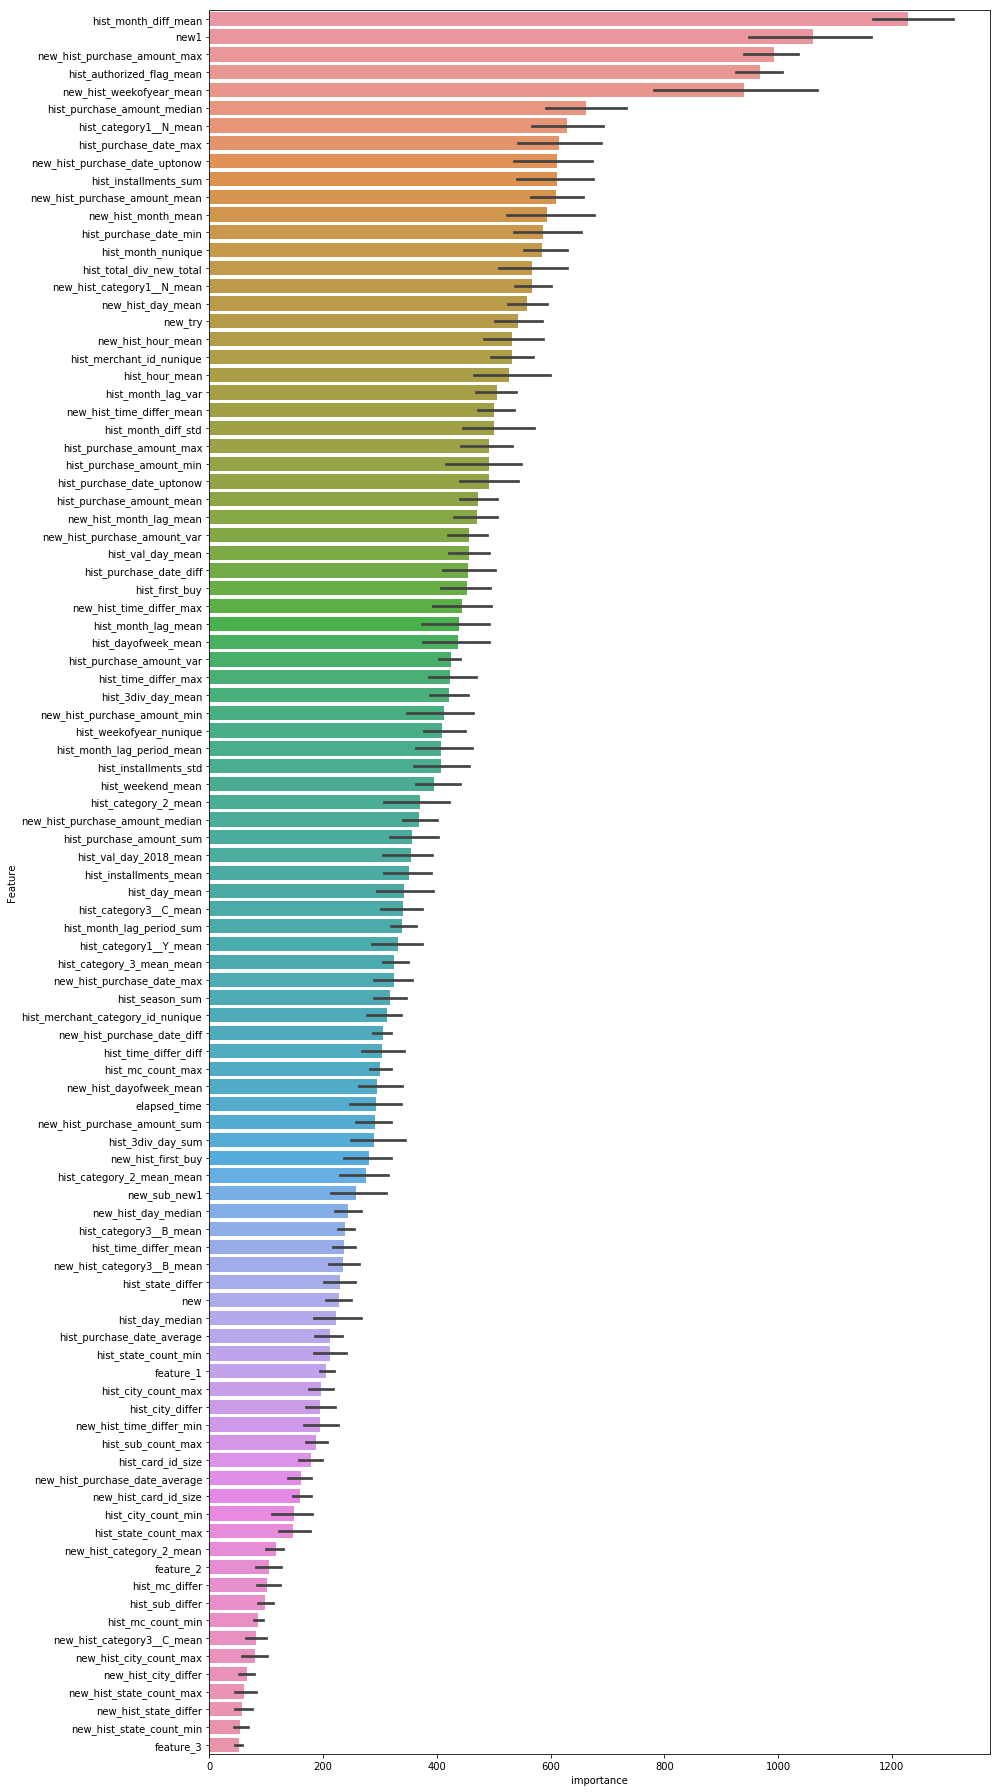

In [28]:
def save_importances(importances_):
    mean_gain = importances_[['importance', 'Feature']].groupby('Feature').mean()
    importances_['mean_gain'] = importances_['Feature'].map(mean_gain['importance'])
    plt.figure(figsize=(14, 25))
    sns.barplot(x='importance', y='Feature', data=importances_.sort_values('mean_gain', ascending=False))
    plt.tight_layout()
    plt.savefig('importances.png')
save_importances(importances_=feature_importance_df)

In [29]:
#Keep new_try and delete new_sub_new1 score was:3.6495 for lgb with all score:3.6501 Stack:3.64598
df_train_columns.remove('new_sub_new1')

In [30]:
import xgboost as xgb
xgb_params= {

               'objective' : "reg:linear", 
               'eval_metric' : "rmse",
               'max_depth' : 7,
               'eta' : 0.05,
               'gamma' : 0,
               'subsample' : 0.7,   
               'colsample_bytree' : 0.7,
               'min_child_weight' : 100,  
               'colsample_bylevel' : 0.7,
               'lambda' : 0.1, 
               'alpha' : 0.1,
               'booster' : "gbtree",
               'silent' : 1
}

out=df_train['outliers']
folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
clfsxg=[]
oof_predxg=np.zeros(len(df_train))
predictionsxg=np.zeros(len(df_test))
feature_importance_df=pd.DataFrame()
for fold_, (trn_, val_) in enumerate(folds.split(df_train, out)):
    
    print('Fold {}'.format(fold_))
    train_data=xgb.DMatrix(df_train.iloc[trn_][df_train_columns], label=target.iloc[trn_])
    val_data=xgb.DMatrix(df_train.iloc[val_][df_train_columns], label=target.iloc[val_])
    watchlist=[(train_data, 'train'), (val_data, 'val')]

    num_round=100000
    clfxg=xgb.train(xgb_params, train_data, num_round, watchlist, early_stopping_rounds=200, verbose_eval=200)
    oof_predxg[val_]=clfxg.predict(xgb.DMatrix(df_train.iloc[val_][df_train_columns]), ntree_limit=clfxg.best_ntree_limit)
    
    
    predictionsxg +=clfxg.predict(xgb.DMatrix(df_test[df_train_columns]), ntree_limit=clfxg.best_ntree_limit)/folds.n_splits
    clfsxg.append(clfxg)
np.sqrt(mean_squared_error(oof_predxg, target))

Fold 0
[0]	train-rmse:3.92548	val-rmse:3.93903
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[200]	train-rmse:3.43357	val-rmse:3.64519
[400]	train-rmse:3.32224	val-rmse:3.65169
Stopping. Best iteration:
[212]	train-rmse:3.42599	val-rmse:3.6449

Fold 1
[0]	train-rmse:3.92855	val-rmse:3.92862
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[200]	train-rmse:3.43571	val-rmse:3.64981
Stopping. Best iteration:
[197]	train-rmse:3.43715	val-rmse:3.64954

Fold 2
[0]	train-rmse:3.92737	val-rmse:3.93936
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[200]	train-rmse:3.43259	val-rmse:3.65385
Stopping. Best iteration:
[142]	train-rmse:3.4713	val-rmse:3.65347

Fold 3
[0]	train-rmse:3.93008	val-rmse:3.93021
Multiple eval

3.6495458137934036

In [31]:
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import BayesianRidge

train_stack = np.vstack([oof,oof_predxg]).transpose()
test_stack = np.vstack([predictions, predictionsxg]).transpose()
#valid_stack = np.vstack([val20, val21,val22]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=1, random_state=120)
oof_stack = np.zeros(train_stack.shape[0])
predictions_3 = np.zeros(test_stack.shape[0])
#vals = np.zeros(valid_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions_3 += clf_3.predict(test_stack) / 5
    #vals +=clf_3.predict(valid_stack)/5

print(np.sqrt(mean_squared_error(target.values, oof_stack)))
#print(np.sqrt(mean_squared_error(target_test.values, vals)))

fold 0
fold 1
fold 2
fold 3
fold 4
3.6459888707427757


## POST-PROCESS

In [32]:
df_without_outlier=df_train[df_train['outliers']==0]
target_wo=df_without_outlier['target']
#del df_without_outlier['target']

In [33]:
param = {
        'objective':'regression',
         'num_leaves': 31,
         'min_data_in_leaf': 30,
         'max_depth': -1,
         'learning_rate': 0.015,
         'lambda_l1':0.13,
         "boosting": "gbdt",
         "feature_fraction":0.8,
         'bagging_freq':8,
         "bagging_fraction": 0.9 ,
         "metric": 'rmse',
         "verbosity": -1,
         "random_state": 4590
}

In [34]:
%%time
folds = KFold(n_splits=5, shuffle=True, random_state=4590)
oof_wo = np.zeros(len(df_without_outlier))
predictions_wo = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_without_outlier,target_wo)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_without_outlier.iloc[trn_idx][df_train_columns], label=target_wo.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_without_outlier.iloc[val_idx][df_train_columns], label=target_wo.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval= 100, early_stopping_rounds = 200)
    oof_wo[val_idx] = clf.predict(df_without_outlier.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_wo += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof_wo, target_wo)**0.5))


fold 0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.58152	valid_1's rmse: 1.61428
[200]	training's rmse: 1.55374	valid_1's rmse: 1.59304
[300]	training's rmse: 1.53943	valid_1's rmse: 1.58529
[400]	training's rmse: 1.52888	valid_1's rmse: 1.58161
[500]	training's rmse: 1.52044	valid_1's rmse: 1.57931
[600]	training's rmse: 1.51332	valid_1's rmse: 1.5784
[700]	training's rmse: 1.50677	valid_1's rmse: 1.57772
[800]	training's rmse: 1.50067	valid_1's rmse: 1.57719
[900]	training's rmse: 1.49472	valid_1's rmse: 1.57671
[1000]	training's rmse: 1.48923	valid_1's rmse: 1.57646
[1100]	training's rmse: 1.48406	valid_1's rmse: 1.57638
[1200]	training's rmse: 1.47884	valid_1's rmse: 1.57631
[1300]	training's rmse: 1.47346	valid_1's rmse: 1.57605
[1400]	training's rmse: 1.46848	valid_1's rmse: 1.57588
[1500]	training's rmse: 1.46347	valid_1's rmse: 1.57576
[1600]	training's rmse: 1.45884	valid_1's rmse: 1.57574
[1700]	training's rmse: 1.4538	valid_1's rms

In [35]:
model_without_outliers = pd.DataFrame({"card_id":df_test["card_id"].values})
model_without_outliers["target"] = predictions_wo

In [ ]:
# target.max()

In [36]:
target_out = df_train['outliers']
target=df_train['target']
#del df_train['outliers']
#del df_train['target']

In [37]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "random_state": 4590}

In [38]:
import time
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
folds = KFold(n_splits=5, shuffle=True, random_state=4590)
oof_po = np.zeros(len(df_train))
predictions_po = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

start = time.time()


for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target_out.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target_out.iloc[trn_idx])#categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target_out.iloc[val_idx])#categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof_po[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_po += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(log_loss(target_out, oof_po)))
print("CV score: {:<8.5f}".format(roc_auc_score(target_out, oof_po)))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.931241	valid_1's auc: 0.901987
[200]	training's auc: 0.948044	valid_1's auc: 0.905693
[300]	training's auc: 0.960352	valid_1's auc: 0.907333
[400]	training's auc: 0.967097	valid_1's auc: 0.90837
[500]	training's auc: 0.972405	valid_1's auc: 0.908594
[600]	training's auc: 0.977228	valid_1's auc: 0.908725
[700]	training's auc: 0.981088	valid_1's auc: 0.908522
[800]	training's auc: 0.983943	valid_1's auc: 0.908283
Early stopping, best iteration is:
[609]	training's auc: 0.977556	valid_1's auc: 0.90884
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.932529	valid_1's auc: 0.901271
[200]	training's auc: 0.947361	valid_1's auc: 0.905522
[300]	training's auc: 0.960726	valid_1's auc: 0.906725
[400]	training's auc: 0.968141	valid_1's auc: 0.906651
[500]	training's auc: 0.97327	valid_1's auc: 0.906036
Early stopping, best iteration is:
[316]	training's au

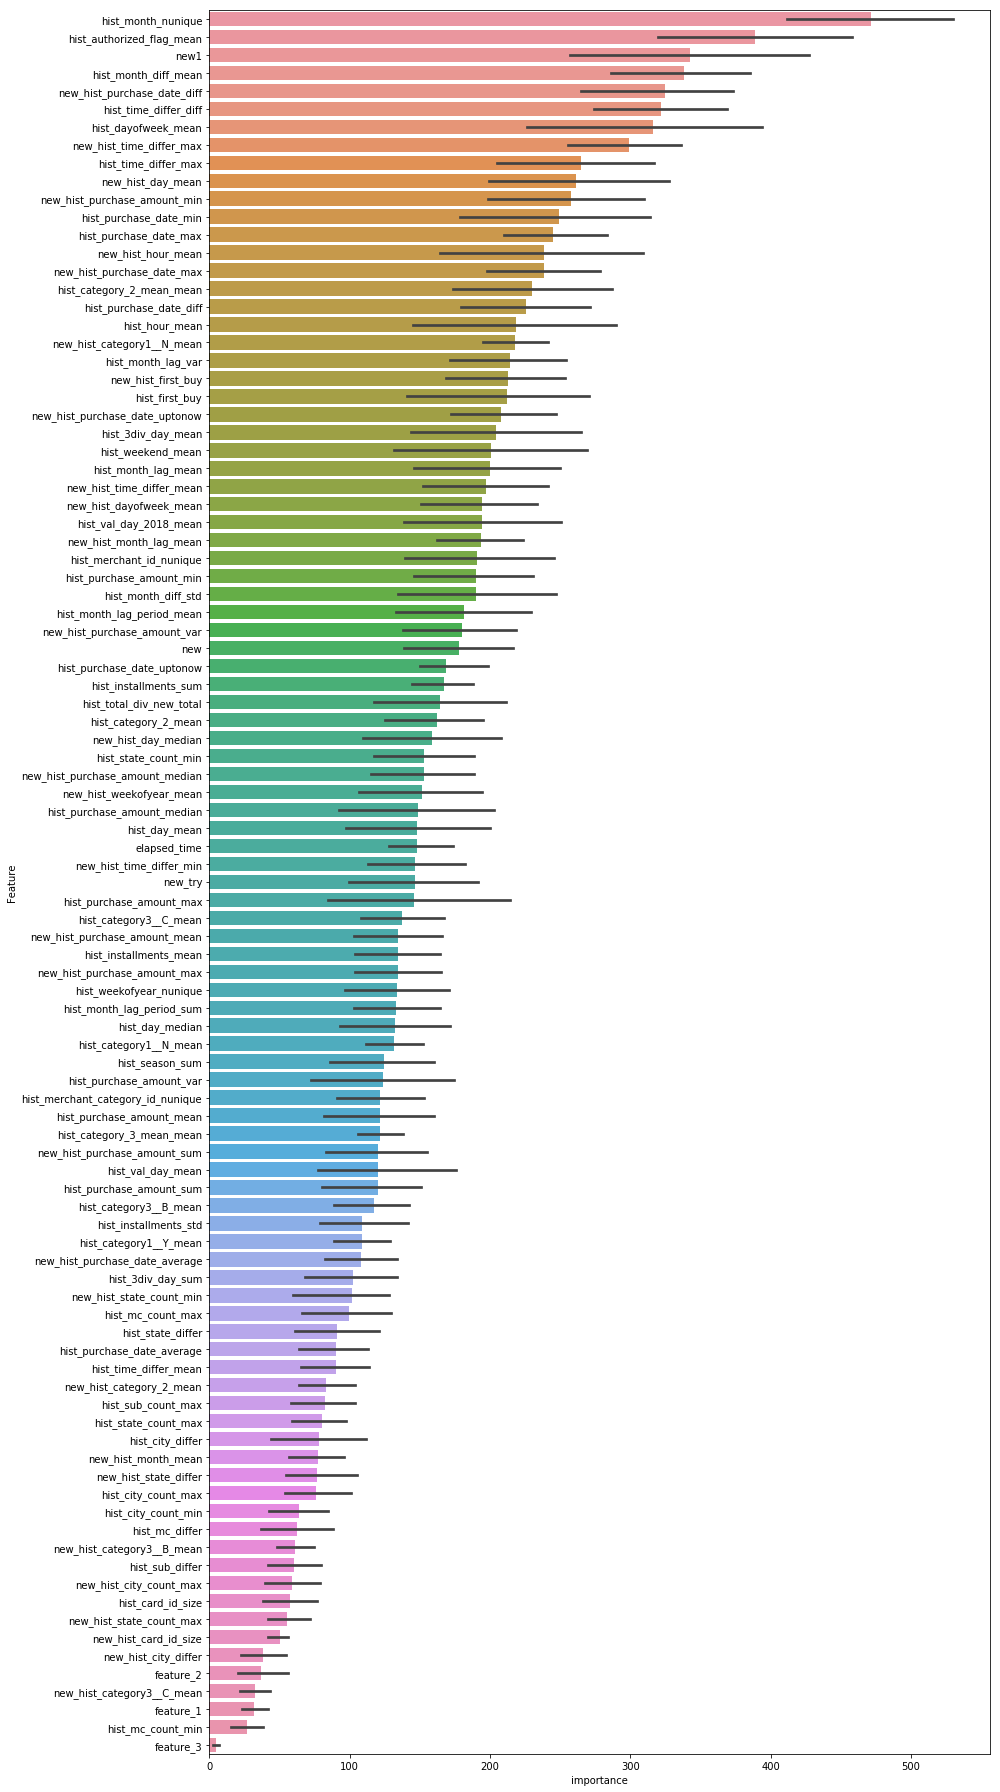

In [39]:
save_importances(importances_=feature_importance_df)

In [ ]:
# list(feature_importance_df.sort_values(by='mean_gain', ascending=False)['Feature'][::5][-5:])

In [40]:
df_outlier_prob = pd.DataFrame({"card_id":df_test["card_id"].values})
df_outlier_prob["target"] = predictions_po
df_outlier_prob.head()

,card_id,target
0,C_ID_0ab67a22ab,0.041571
1,C_ID_130fd0cbdd,0.001713
2,C_ID_b709037bc5,0.011690
3,C_ID_d27d835a9f,0.000315
4,C_ID_2b5e3df5c2,0.001875


In [41]:
bigger_than_04=df_outlier_prob[df_outlier_prob['target']>0.4]
print(bigger_than_04)
print(bigger_than_04.shape)

                card_id    target
1772    C_ID_4299911620  0.401706
2726    C_ID_1edbae8171  0.406328
5008    C_ID_be92f84f5c  0.429563
5656    C_ID_126a403be9  0.478827
6026    C_ID_91cc0c06ca  0.515695
7750    C_ID_a74b12dcf8  0.413390
13254   C_ID_c197a62602  0.431252
16074   C_ID_9c760806b5  0.443900
19114   C_ID_0be3fb41d2  0.505033
20556   C_ID_aae50409e7  0.471445
23168   C_ID_3804897561  0.418388
25568   C_ID_767923bdb9  0.427013
27314   C_ID_7f5f950342  0.457453
27340   C_ID_e4a5ea82d4  0.411019
27436   C_ID_493de71141  0.414694
30248   C_ID_65a0e440f8  0.427364
32446   C_ID_ac114ef831  0.598799
41138   C_ID_d706b6696a  0.434285
43215   C_ID_dc60219f6c  0.431006
57626   C_ID_944c62886f  0.408135
59178   C_ID_a4dfae60b0  0.413486
61601   C_ID_55f33eeda6  0.437616
65911   C_ID_7d3b40444e  0.491797
67665   C_ID_3b5972c942  0.409914
70804   C_ID_833aa2f7af  0.480814
72221   C_ID_464246c0a5  0.411739
77297   C_ID_b0c41ca140  0.405331
78078   C_ID_922f9c5ea6  0.428146
79686   C_ID_a

In [42]:
outlier_id = pd.DataFrame(df_outlier_prob.sort_values(by='target',ascending = False).head(25000)['card_id'])

In [43]:
df_n=pd.DataFrame({'card_id':df_test['card_id'].values})
df_n['target']=predictions_3

In [44]:
best_submission=pd.DataFrame()
best_submission['target']=df_n['target']
best_submission['card_id']=df_n['card_id']

In [45]:
most_likely_liers = best_submission.merge(outlier_id,how='right')
most_likely_liers.head()

,target,card_id
0,-1.982542,C_ID_0ab67a22ab
1,-0.764764,C_ID_b709037bc5
2,0.543796,C_ID_f7cada36d3
3,-0.995130,C_ID_6d8dba8475
4,-5.740035,C_ID_7f1041e8e1


In [46]:
for card_id in most_likely_liers['card_id']:
    model_without_outliers.loc[model_without_outliers['card_id']==card_id,'target']\
    = most_likely_liers.loc[most_likely_liers['card_id']==card_id,'target'].values

In [47]:
model_without_outliers.to_csv("combining_submission1055.csv", index=False)